In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

In [2]:
def train_test_split(window_size):
    data = np.load("./dataset/pems-traffic-flow/PEMS04.npz")
    pem04 = data['data']
    scaler_data = np.zeros((pem04.shape[0], pem04.shape[1], pem04.shape[2]))

    v_scaler = MinMaxScaler()  # 速度归一化
    o_scaler = MinMaxScaler()  # 拥挤程度归一化
    f_scaler = MinMaxScaler()  # 车流量归一化

    scaler_data[:, :, 0] = f_scaler.fit_transform(pem04[:, :, 0])  # 车流量
    scaler_data[:, :, 1] = o_scaler.fit_transform(pem04[:, :, 1])  # 拥挤程度
    scaler_data[:, :, 2] = v_scaler.fit_transform(pem04[:, :, 2])  # 速度

    ratio = int(pem04.shape[0] * 0.75)
    train_data = scaler_data[:ratio, :, :]
    test_data = scaler_data[ratio:, :, :]

    # 训练集数据时间序列采样
    result = []
    for i in range(len(train_data) - window_size - 1):
        tmp = train_data[i: i + window_size, :, :]
        tmp = tmp.reshape(-1, 307 * 3)
        # 后1min的数据作为label
        label = train_data[i + window_size + 1, :, :].reshape(1, -1)
        tmp = np.concatenate((tmp, label), axis=0)
        result.append(tmp)

    train_loader = DataLoader(result, batch_size=30, shuffle=False)

    test_sets = []

    for i in range(len(test_data) - window_size - 1):
        tmp = test_data[i: i + window_size, :, :]
        tmp = tmp.reshape(-1, 307 * 3)
        # 后1min的数据作为label
        label = test_data[i + window_size + 1, :, :].reshape(1, -1)
        tmp = np.concatenate((tmp, label), axis=0)
        test_sets.append(tmp)
    test_loader = DataLoader(test_sets, batch_size=36, shuffle=False)
    # 返回MinMaxScaler以便反归一化
    return train_loader, test_loader, v_scaler, f_scaler, o_scaler

In [7]:
def train(epoch, train_loader, test_loader, model, optimizer, window_size, criterion, alt):
    train_loss_list = []
    test_loss_list = []
    for i in range(epoch):
        losses = 0
        for batch in train_loader:
            # [src_len, batch, embedded]
            batch = batch.permute(1, 0, 2)
            x = batch[:window_size, :, :].type(torch.float)
            label = batch[-1, :, :].type(torch.float)
            if alt == "my":
                pred, _ = model(x)
                pred = pred[-1, :, :]
            else:
                pred = model(x)
                pred = pred.squeeze(0)
            loss = criterion(pred, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses += loss.item()
        train_loss_list.append(losses)

        print("epoch: {},loss : {}".format(i + 1, losses))
        # 测试集上的loss
        losses = 0
        for batch in test_loader:
            batch = batch.permute(1, 0, 2)
            x = batch[:window_size, :, :].type(torch.float)
            label = batch[-1, :, :].type(torch.float)
            if alt == "my":
                pred, _ = model(x)
                pred = pred[-1, :, :]
            else:
                pred = model(x)
                pred = pred.squeeze(0)
            loss = criterion(pred, label)
            losses += loss.item()
        test_loss_list.append(losses)

    return train_loss_list, test_loss_list


def test(model, test_loader, window_size, criterion, alt):
    model.eval()
    test_loss = 0.0
    test_preds = []
    test_label = []
    for batch in test_loader:
        batch = batch.permute(1, 0, 2)
        x = batch[:window_size, :, :].type(torch.float)
        label = batch[-1, :, :].type(torch.float)
        if alt == "my":
            pred, _ = model(x)
            pred = pred[-1, :, :]
        else:
            pred = model(x)
            pred = pred.squeeze(0)
        test_preds.append(pred)
        test_label.append(label)
        loss = criterion(pred, label)
        test_loss += loss.item()
    print("test loss: {}".format(test_loss))
    return test_preds, test_label

In [30]:
def show_preds(batch, test_preds, test_label, scaler, type, no):
    # 绘制第 no 个探头的速度、车流量、拥挤程度的对比
    # 获取前batch的预测数据
    p = torch.stack(test_preds[:batch], dim=0).reshape(-1, 307, 3)
    t = torch.stack(test_label[:batch], dim=0).reshape(-1, 307, 3)

    predict = scaler.inverse_transform(p[:, :, type].detach().numpy())
    labels = scaler.inverse_transform(t[:, :, type].detach().numpy())
    no_predict = predict[:, no]
    no_labels = labels[:, no]

    x = np.arange(1, p.shape[0] + 1)
    plt.figure(figsize=(15, 9))
    plt.plot(x, no_predict, label='predict')
    plt.plot(x, no_labels, label="original")
    plt.legend()
    plt.show()

In [5]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        # 注意rnn cell并没有h_w这个矩阵
        super().__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        '''
            x: [src_len, batch_size, embedding]
        '''
        _, hidden = self.rnn(x)

        out = self.output(hidden)

        return out

## lr=0.1, hidden_size=256

In [31]:
criterion = nn.MSELoss()
window_size = 6
epoch = 20
lr = 0.1
model = RNNModel(3 * 307, 256, 3 * 307)
optimizer = optim.SGD(model.parameters(), lr=lr)
train_loader, test_loader , v_scaler, f_scaler, o_scaler = train_test_split(window_size)

In [32]:
start = time.time()
train_loss_list, test_loss_list = train(epoch,train_loader,test_loader, model,optimizer,window_size,criterion, "torch")
test_preds, test_label = test(model,test_loader,window_size,criterion,"torch")
stop = time.time()
print(stop-start)

epoch: 1,loss : 19.922611872199923
epoch: 2,loss : 6.396340402541682
epoch: 3,loss : 4.656524018151686
epoch: 4,loss : 4.333223628345877
epoch: 5,loss : 4.19641796220094
epoch: 6,loss : 4.080690169124864
epoch: 7,loss : 3.9662553158123046
epoch: 8,loss : 3.8500412105349824
epoch: 9,loss : 3.7327187715563923
epoch: 10,loss : 3.6169202047167346
epoch: 11,loss : 3.5062310248613358
epoch: 12,loss : 3.404052695725113
epoch: 13,loss : 3.312672738567926
epoch: 14,loss : 3.23289561632555
epoch: 15,loss : 3.1642389902845025
epoch: 16,loss : 3.105419574712869
epoch: 17,loss : 3.054836690076627
epoch: 18,loss : 3.0109054884524085
epoch: 19,loss : 2.9722292832448147
epoch: 20,loss : 2.9376579626696184
test loss: 0.908138467464596
50.76990103721619


[]

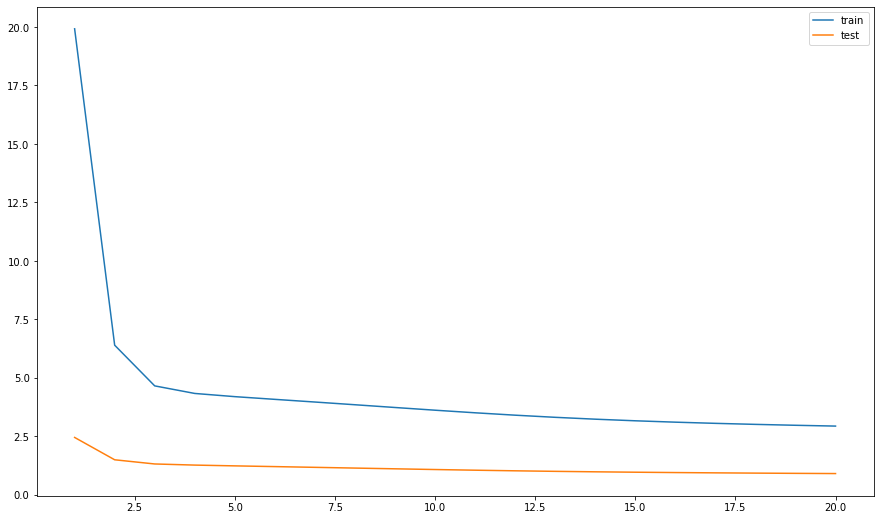

In [33]:
#绘制loss曲线变化图
epoches = np.arange(1, epoch + 1)
train_loss_list = np.array(train_loss_list)
test_loss_list = np.array(test_loss_list)
plt.figure(figsize=(15, 9))
plt.plot(epoches, train_loss_list, label = "train")
plt.plot(epoches, test_loss_list, label = "test")
plt.legend()
plt.plot()

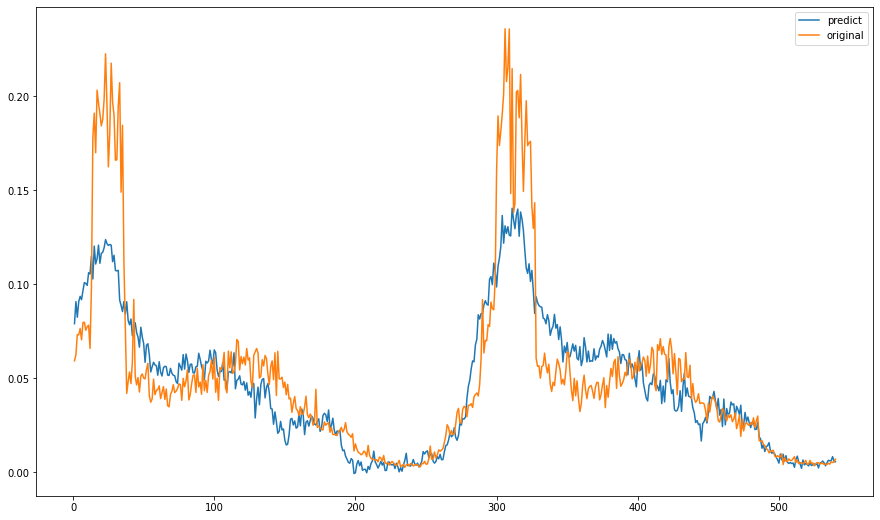

In [34]:
show_preds(15,test_preds,test_label,o_scaler,1,0)

## lr=0.01, hidden_size=256

In [35]:
criterion = nn.MSELoss()
window_size = 6
epoch = 20
lr = 0.01
model = RNNModel(3 * 307, 256, 3 * 307)
optimizer = optim.SGD(model.parameters(), lr=lr)
train_loader, test_loader , v_scaler, f_scaler, o_scaler = train_test_split(window_size)

In [36]:
start = time.time()
train_loss_list, test_loss_list = train(epoch,train_loader,test_loader, model,optimizer,window_size,criterion, "torch")
test_preds, test_label = test(model,test_loader,window_size,criterion,"torch")
stop = time.time()
print(stop-start)

epoch: 1,loss : 87.67168264091015
epoch: 2,loss : 26.216258021071553
epoch: 3,loss : 13.815113629214466
epoch: 4,loss : 11.911443368066102
epoch: 5,loss : 11.21513634454459
epoch: 6,loss : 10.645966716576368
epoch: 7,loss : 10.089193626306951
epoch: 8,loss : 9.53456179285422
epoch: 9,loss : 8.985695446841419
epoch: 10,loss : 8.449785149656236
epoch: 11,loss : 7.935603562742472
epoch: 12,loss : 7.452037640847266
epoch: 13,loss : 7.006722507067025
epoch: 14,loss : 6.605070794932544
epoch: 15,loss : 6.249829109758139
epoch: 16,loss : 5.941123490221798
epoch: 17,loss : 5.676872407551855
epoch: 18,loss : 5.45341279450804
epoch: 19,loss : 5.266173996264115
epoch: 20,loss : 5.110263672890142
test loss: 1.488815609132871
51.670287132263184


[]

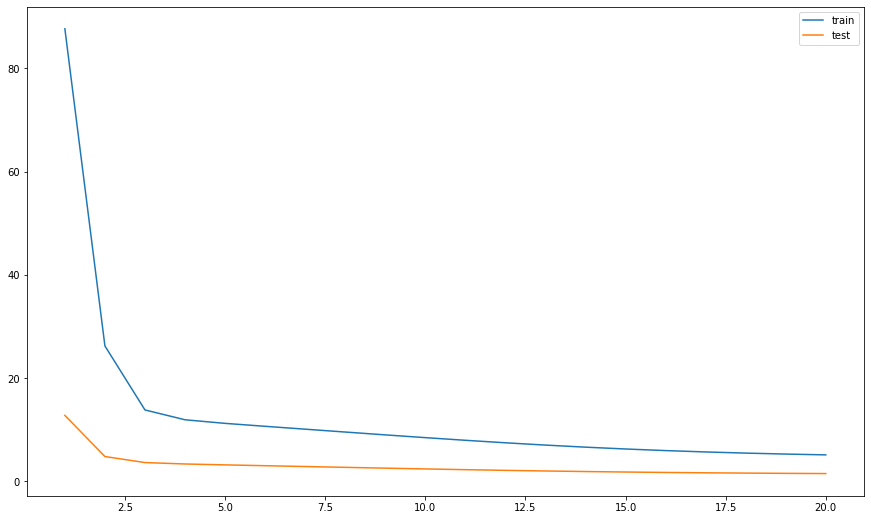

In [39]:
#绘制loss曲线变化图
epoches = np.arange(1, epoch + 1)
train_loss_list = np.array(train_loss_list)
test_loss_list = np.array(test_loss_list)
plt.figure(figsize=(15, 9))
plt.plot(epoches, train_loss_list, label = "train")
plt.plot(epoches, test_loss_list, label = "test")
plt.legend()
plt.plot()

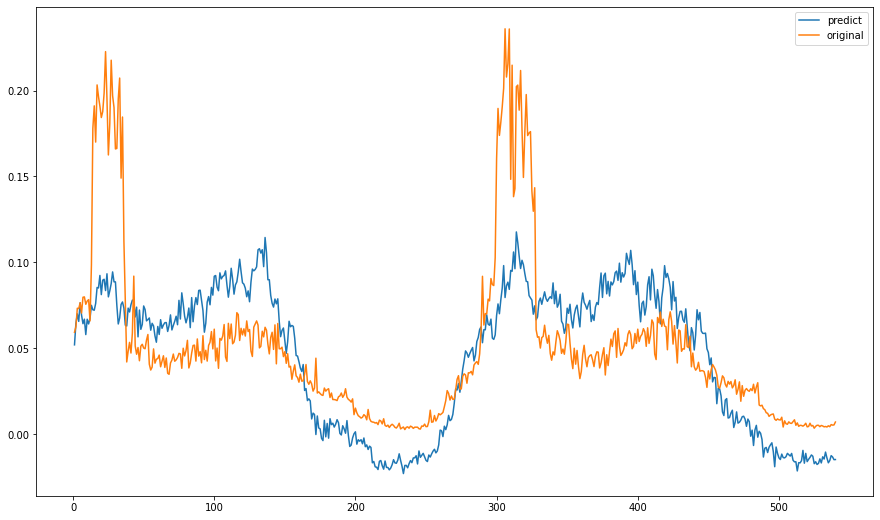

In [40]:
show_preds(15,test_preds,test_label,o_scaler,1,0)

## lr=0.001, hidden_size=256

In [41]:
criterion = nn.MSELoss()
window_size = 6
epoch = 20
lr = 0.001
model = RNNModel(3 * 307, 256, 3 * 307)
optimizer = optim.SGD(model.parameters(), lr=lr)
train_loader, test_loader , v_scaler, f_scaler, o_scaler = train_test_split(window_size)

In [42]:
start = time.time()
train_loss_list, test_loss_list = train(epoch,train_loader,test_loader, model,optimizer,window_size,criterion, "torch")
test_preds, test_label = test(model,test_loader,window_size,criterion,"torch")
stop = time.time()
print(stop-start)

epoch: 1,loss : 151.17419943213463
epoch: 2,loss : 125.27428194880486
epoch: 3,loss : 109.20283307135105
epoch: 4,loss : 96.60643698275089
epoch: 5,loss : 85.57083812355995
epoch: 6,loss : 75.49506168067455
epoch: 7,loss : 66.24169832468033
epoch: 8,loss : 57.83395027369261
epoch: 9,loss : 50.32571367919445
epoch: 10,loss : 43.74621757119894
epoch: 11,loss : 38.08342045545578
epoch: 12,loss : 33.28710686042905
epoch: 13,loss : 29.27995489910245
epoch: 14,loss : 25.969909828156233
epoch: 15,loss : 23.26061370410025
epoch: 16,loss : 21.058858858421445
epoch: 17,loss : 19.27914835140109
epoch: 18,loss : 17.845978969708085
epoch: 19,loss : 16.69451316073537
epoch: 20,loss : 15.770226696506143
test loss: 4.499209687113762
51.87455081939697


[]

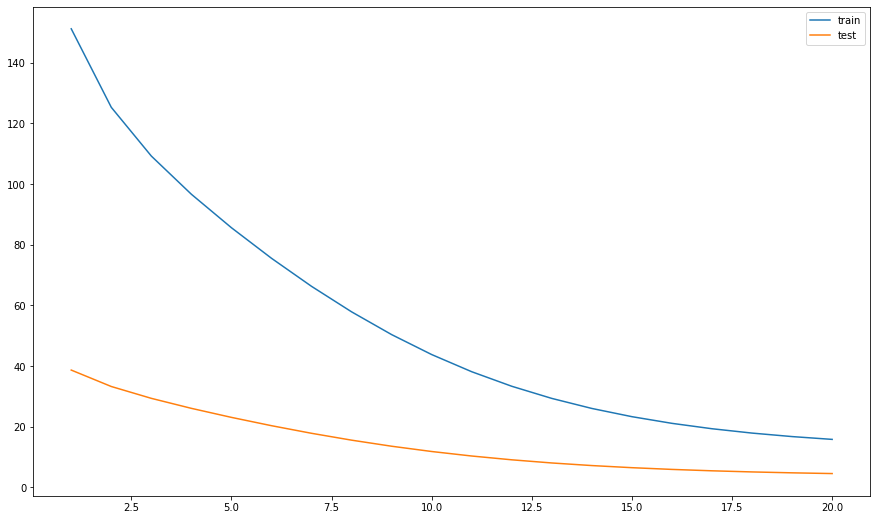

In [43]:
#绘制loss曲线变化图
epoches = np.arange(1, epoch + 1)
train_loss_list = np.array(train_loss_list)
test_loss_list = np.array(test_loss_list)
plt.figure(figsize=(15, 9))
plt.plot(epoches, train_loss_list, label = "train")
plt.plot(epoches, test_loss_list, label = "test")
plt.legend()
plt.plot()

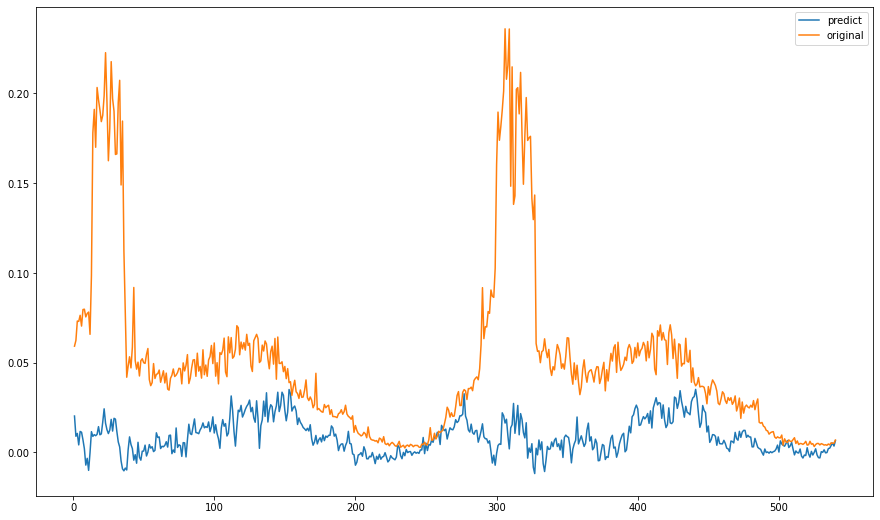

In [44]:
show_preds(15,test_preds,test_label,o_scaler,1,0)

## lr=0.1, hidden_size=512

In [45]:
criterion = nn.MSELoss()
window_size = 6
epoch = 20
lr = 0.1
model = RNNModel(3 * 307, 512, 3 * 307)
optimizer = optim.SGD(model.parameters(), lr=lr)
train_loader, test_loader , v_scaler, f_scaler, o_scaler = train_test_split(window_size)

In [46]:
start = time.time()
train_loss_list, test_loss_list = train(epoch,train_loader,test_loader, model,optimizer,window_size,criterion, "torch")
test_preds, test_label = test(model,test_loader,window_size,criterion,"torch")
stop = time.time()
print(stop-start)

epoch: 1,loss : 14.080732805188745
epoch: 2,loss : 4.61872586060781
epoch: 3,loss : 4.103871240396984
epoch: 4,loss : 3.8928645325358957
epoch: 5,loss : 3.6903872644761577
epoch: 6,loss : 3.4928211694350466
epoch: 7,loss : 3.313112025090959
epoch: 8,loss : 3.163453283836134
epoch: 9,loss : 3.0465673973667435
epoch: 10,loss : 2.956880471028853
epoch: 11,loss : 2.886488832125906
epoch: 12,loss : 2.828823119169101
epoch: 13,loss : 2.779403888329398
epoch: 14,loss : 2.7354455623426475
epoch: 15,loss : 2.6953025510301813
epoch: 16,loss : 2.6580378648941405
epoch: 17,loss : 2.6231353082694113
epoch: 18,loss : 2.590318688133266
epoch: 19,loss : 2.5594416214735247
epoch: 20,loss : 2.5304213133640587
test loss: 0.8034597695805132
114.2314932346344


[]

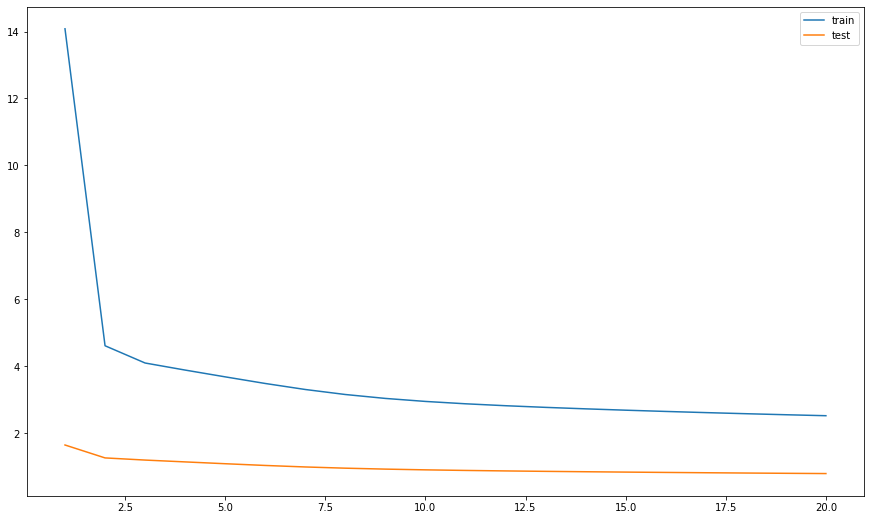

In [47]:
#绘制loss曲线变化图
epoches = np.arange(1, epoch + 1)
train_loss_list = np.array(train_loss_list)
test_loss_list = np.array(test_loss_list)
plt.figure(figsize=(15, 9))
plt.plot(epoches, train_loss_list, label = "train")
plt.plot(epoches, test_loss_list, label = "test")
plt.legend()
plt.plot()

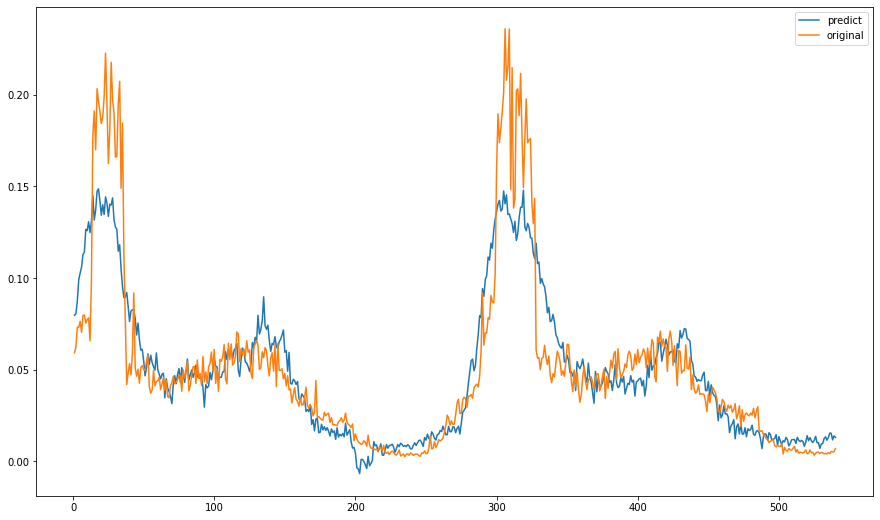

In [48]:
show_preds(15,test_preds,test_label,o_scaler,1,0)

## lr=0.1, hidden_size=1024

In [49]:
criterion = nn.MSELoss()
window_size = 6
epoch = 20
lr = 0.1
model = RNNModel(3 * 307, 1024, 3 * 307)
optimizer = optim.SGD(model.parameters(), lr=lr)
train_loader, test_loader , v_scaler, f_scaler, o_scaler = train_test_split(window_size)

In [50]:
start = time.time()
train_loss_list, test_loss_list = train(epoch,train_loader,test_loader, model,optimizer,window_size,criterion, "torch")
test_preds, test_label = test(model,test_loader,window_size,criterion,"torch")
stop = time.time()
print(stop-start)

epoch: 1,loss : 11.309418376535177
epoch: 2,loss : 4.0572580406442285
epoch: 3,loss : 3.703674160060473
epoch: 4,loss : 3.402119728620164
epoch: 5,loss : 3.1381706360843964
epoch: 6,loss : 2.9507005983614363
epoch: 7,loss : 2.8303916773293167
epoch: 8,loss : 2.7465346418321133
epoch: 9,loss : 2.679664046445396
epoch: 10,loss : 2.621154261752963
epoch: 11,loss : 2.5676117360126227
epoch: 12,loss : 2.5179049714352004
epoch: 13,loss : 2.4718339879764244
epoch: 14,loss : 2.4295144549105316
epoch: 15,loss : 2.3910773433744907
epoch: 16,loss : 2.356529610522557
epoch: 17,loss : 2.3257142250658944
epoch: 18,loss : 2.298332062724512
epoch: 19,loss : 2.2739935460849665
epoch: 20,loss : 2.2522741749417037
test loss: 0.7412230679765344
339.89921712875366


[]

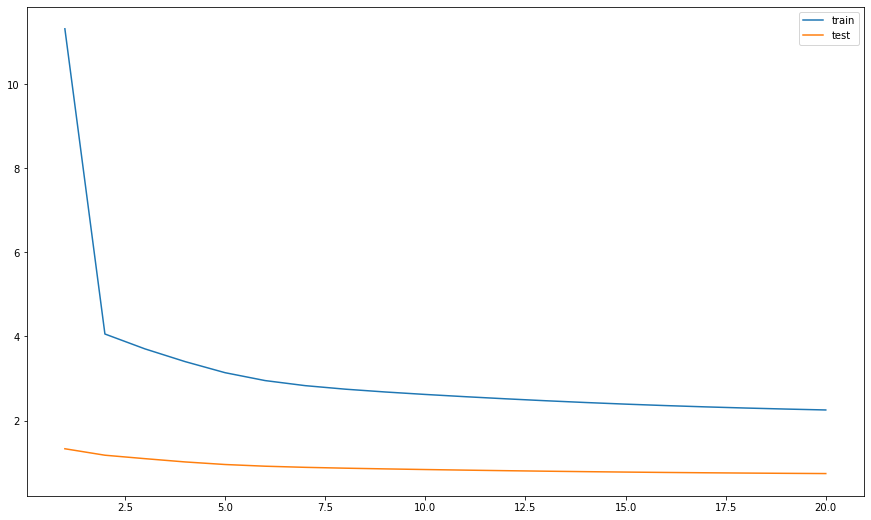

In [51]:
#绘制loss曲线变化图
epoches = np.arange(1, epoch + 1)
train_loss_list = np.array(train_loss_list)
test_loss_list = np.array(test_loss_list)
plt.figure(figsize=(15, 9))
plt.plot(epoches, train_loss_list, label = "train")
plt.plot(epoches, test_loss_list, label = "test")
plt.legend()
plt.plot()

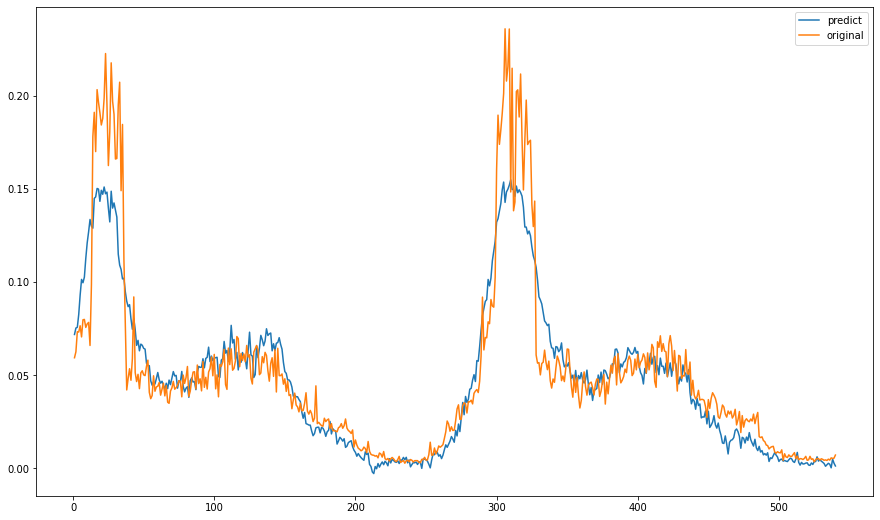

In [52]:
show_preds(15,test_preds,test_label,o_scaler,1,0)